# Machine-leaned Kohn-Sham Hamiltonian mapping for computation of the molecular orbital overlaps and time-overlaps 

In this tutorial, we use machine-learning to perform [step 2](../../../7_step2_cp2k) calculations. 
This approach uses Kohn-Sham Hamiltonian mapping approach where the atomic-guess Hamiltonians from a PBE calculations are 
directly mapped into B3LYP Hamiltonians. The molecular orbitals obtained from solving generalized Kohn-Sham equations
are used to compute the overlaps and time-overlap matrices. One can then use these data for [step3](../../../8_step3) and 
[step4](../../../9_step4) calculations.


## Table of contents
<a name="toc"></a>
1. [Importing needed libraries](#import)


2. [Overview of required files](#required_files)


3. [Training machine-learning model](#train_model)


4. [Using machine-learning model](#use_model)


5. [Plotting machine-learned energies](#plot_data)


### A. Learning objectives

* To be able to compute molecular orbital overlap calculations on using machine-learning techniques

### B. Use cases

* [Training machine-learning model](#train_model)

* [Using machine-learning model](#use_model)

* [Plotting machine-learned energies](#plot_data)


### C. Functions

- `libra_py.workflows.nbra`
  - `ml_map`
    - [`train`](#train_model)
    - [`load_models`](#use_model)
    - [`compute_properties`](#use_model)

## 1. Importing needed libraries <a name="import"></a>
[Back to TOC](#toc)

Import `train`, `load_models`, and `compute_properties` function from `ml_map` module using the following commands:

In [18]:
import os
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from libra_py import units
from libra_py.workflows.nbra.ml_map import train, load_models, compute_properties

## 2. Overview of required files <a name="required_files"></a>
[Back to TOC](#toc)

To train the machine-learning model, one requires a set of inputs and outputs. These inputs and outputs 
were already obtained in the [previous step](../1_generate_data). The inputs are atomic-guess PBE Hamiltonians
and the outputs are converged B3LYP Hamiltonians obtained for a couple of randomly selected geometries of a precomputed
trajectory. The input data are stored with a prefix and a property and the output data have an extra `_ref_` in their names.

# 3. Training machine-learning model <a name="train_model"></a>
[Back to TOC](#toc)

Here are the set of parameters required to train a machine-learning model using `train` function in `ml_map` module.


`prefix`: The prefix used to save the files.

`path_to_input_mats`: The full path to input matrices files.

`path_to_output_mats`: The full path to output matrices files.

`path_to_trajectory_xyz_file`: The full path to trajectory `xyz` file. This is required for computation of the overlap
matrix and solving generalized Kohn-Sham equations. Also, it will be required for computation of the molecular orbitals 
overlap and time-overlap matrices.

`path_to_sample_files`: The full path to sample files obtained in the [generate data step](../1_generate_data).

`input_property`: The input property which appears in the middle of the name of the input files. It can take values of `kohn_sham`, `density`, `overlap`, and `hamiltonian` for xTB calculations.

`output_property`: The output property which appears in the middle of the name of the output files. It can take values of `kohn_sham`, `density`, `overlap`, and `hamiltonian` for xTB calculations.
    
We use a kernel ridge regression (KRR) method for mapping the Hamiltonian matrix from one calculations to another. The parameters for setting up the KRR are as follows:
    
`kernel`: The kernel name: `linear`, `poly` for polynomial kernels, and `rbf` for radial basis function kernel.

`degree`: The degree of the kernel function in case of a `poly` kernel.

`alpha`: This parameter represents the regularization strength in ridge regression. It controls the complexity of the model: a higher alpha value increases the amount of regularization, which in turn reduces the model's variance but might increase its bias. Specifically, it multiplies the identity matrix that is added to the kernel matrix in the ridge regression formula. This parameter helps to prevent overfitting by ensuring that the coefficients do not grow too large.


`gamma`: This parameter is specific to certain types of kernels such as the radial basis function, sigmoid, or polynomial kernels. Gamma defines how much influence a single training input has. The larger the gamma, the closer other inputs must be to be affected.

`scaler`: The scaler to scale the input and data. It can take `standard_scaler` and `minmax_scaler` values. The `standard_scaler` is recommended.

`save_models`: A boolean flag for saving the trained model 

`path_to_save_models`: The full path to save the model

`save_ml_ham`: A boolean flag for saving the predicted Hamiltonian matrices 

`save_ao_overlap`: A boolean flag for saving the atomic orbital overlap matrices

`save_ml_mos`: A boolean flag for saving the molecular orbitals eigenvalues and eigenvectors


`partitioning_method`: The partitioning of the Hamiltonian matrix. It can take values of `equal` and `atomic`. In the 
`equal` partitioning, the upper triangular part of the Hamiltonian matrix is partitioned into `npartition` equal segments. 
A separate model maps each input partition to its corresponding partition in the output matrix.\
The `atomic` partitioning method partitions the matrix based on the atomic angular momentum components of the matrix for each
basis set.

`npartition`: The number of partition in the `equal` partitioning method.

`memory_efficient`: A boolean flag for memory efficiency of the calculations. This will remove the raw data and will remove them 
from the memory after they are processed.

`nprocs`: The number of processors for computing the overlap matrices.

`write_wfn_file`: A boolean flag for writing `wfn` files readable by CP2K.

`path_to_save_wfn_files`: The full path to save the `wfn` files.

`is_periodic`: The flag for periodicity of he system for computing the overlaps.

`A_cell_vector`: A list containing the A cell vector.

`B_cell_vector`: A list containing the B cell vector.

`C_cell_vector`: A list containing the C cell vector.

`periodicity_type`: The periodicity type for each direction of the periodic cell.

`lowest_orbital`: The lowest orbital index to be saved.

`highest_orbital`: The highest orbital index to be saved.

`res_dir`: The full path to save the overlap, time-overlap, and energies similar as in [step 2](../../../7_step2_cp2k).

`train_parallel`: A boolean flag for training models in parallel.


In [4]:
params = { # Part 1
    "prefix": "c60",
    "path_to_input_mats": os.getcwd() + "/../1_generate_data/guess",
    "path_to_output_mats": os.getcwd() + "/../1_generate_data/ref",
    "path_to_trajectory_xyz_file": os.getcwd() + "/../1_generate_data/C60-pos-1.xyz",
    "path_to_sample_files": os.getcwd() + "/../1_generate_data/sample_files",
    "input_property":  "kohn_sham",
    "output_property": "kohn_sham",
    # Part 2 
    "kernel":"linear",
    "degree": 1,
    "alpha": 0.02,
    "gamma": 0.02,
    "scaler": "standard_scaler", # "minmax_scaler"
    "save_models": True,
    # The next savings are only for 
    # development purposes so it's recommended to turn them off
    # since they will occupy a huge amount of disk space
    "save_ml_ham": False,
    "save_ao_overlap": False,
    "save_ml_mos": False,
    "path_to_save_models": os.getcwd() + "/models",
    "partitioning_method": "equal", # Optios: "equal" and "atomic"
    "npartition": 60,
    "memory_efficient": True,
    "train_parallel": False,
    # Part 3
    "compute_overlap": True,
    "nprocs": 8,
    "write_wfn_file": True,
    "path_to_save_wfn_files": os.getcwd() + "/wfn_files",
    "istep": 0,
    "is_periodic": False,
    "A_cell_vector": [10.0, 0.0, 0.0],
    "B_cell_vector": [0.0, 10.0, 0.0],
    "C_cell_vector": [0.0, 0.0, 10.0],
    "periodicity_type": "XYZ",
    "lowest_orbital": 100,
    "highest_orbital": 140,
    "res_dir": os.getcwd() + "/res"}

models, models_error, input_scalers, output_scalers = train(params)

Training R^2: 0.9999998307113434
Training MSE: 7.628980443753991e-13   MAE: 2.1310102402240974e-07
Training R^2: 0.9999995669986604
Training MSE: 6.682178316234825e-13   MAE: 2.0641800169632275e-07
Training R^2: 0.9999999127701016
Training MSE: 7.524487847719702e-13   MAE: 2.0914870104186396e-07
Training R^2: 0.999999564475302
Training MSE: 4.780142442502884e-13   MAE: 1.577124777407067e-07
Training R^2: 0.9999998971693181
Training MSE: 5.766012497106645e-13   MAE: 1.7374234196768328e-07
Training R^2: 0.9999996250503733
Training MSE: 7.214455751283025e-13   MAE: 1.7657013819051605e-07
Training R^2: 0.9999997538100934
Training MSE: 8.774782538680085e-13   MAE: 1.9626980723732602e-07
Training R^2: 0.9999997609014332
Training MSE: 8.179127919023132e-13   MAE: 1.9304698635682104e-07
Training R^2: 0.9999997298013492
Training MSE: 1.1324505238324741e-12   MAE: 2.1345085534480295e-07
Training R^2: 0.9999998377356705
Training MSE: 5.833688292604902e-13   MAE: 1.5970517396240485e-07
Training R^

mkdir: cannot create directory ‘/projects/academic/alexeyak/mohammad/my_repositories/Tutorials_Libra/6_dynamics/2_nbra_workflows/16_ml_hamiltonian_mapping/1_c60/2_ml_step2/models’: File exists


# 4. Using machine-learning model <a name="use_model"></a>
[Back to TOC](#toc)

Here, we use the trained models to compute the properties such as the molecular orbitals with their overlap and time-overlaps.
One can either load the models using `load_models` function, in case of `"save_models": True` or they can reuse the `models` and other variables from output by `train` function. 

The `load_models` take two positional arguments: 

* The full path to saved models.
* The dictionary defined above.

After the models are trained or loaded, one can use `compute_properties` function to predict the molecular orbitals and 
their properties. This function will compute the properties for all guess input data in guess directory, the `params["path_to_input_mats"]`.

This is how you can load models:

In [5]:
# You can also reload the saved models that are already trained with input and output data
models, models_error, input_scalers, output_scalers = load_models(os.getcwd()+'/models', params)

Loading models...
Done with loading models!...


Now, we can use them:

In [6]:
compute_properties(params, models, input_scalers, output_scalers)

mkdir: cannot create directory ‘/projects/academic/alexeyak/mohammad/my_repositories/Tutorials_Libra/6_dynamics/2_nbra_workflows/16_ml_hamiltonian_mapping/1_c60/2_ml_step2/wfn_files’: File exists
mkdir: cannot create directory ‘/projects/academic/alexeyak/mohammad/my_repositories/Tutorials_Libra/6_dynamics/2_nbra_workflows/16_ml_hamiltonian_mapping/1_c60/2_ml_step2/res’: File exists


 Performing calculations for step  1000
 Performing calculations for step  1001
 Performing calculations for step  1002
 Performing calculations for step  1003
 Performing calculations for step  1004
 Performing calculations for step  1005
 Performing calculations for step  1006
 Performing calculations for step  1007
 Performing calculations for step  1008
 Performing calculations for step  1009
 Performing calculations for step  1010
 Performing calculations for step  1011
 Performing calculations for step  1012
 Performing calculations for step  1013
 Performing calculations for step  1014
 Performing calculations for step  1015
 Performing calculations for step  1016
 Performing calculations for step  1017
 Performing calculations for step  1018
 Performing calculations for step  1019
 Performing calculations for step  1020
 Performing calculations for step  1021
 Performing calculations for step  1022
 Performing calculations for step  1023
 Performing calculations for step  1024


 Performing calculations for step  1125
 Performing calculations for step  1126
 Performing calculations for step  1127
 Performing calculations for step  1128
 Performing calculations for step  1129
 Performing calculations for step  1130
 Performing calculations for step  1131
 Performing calculations for step  1132
 Performing calculations for step  1133
 Performing calculations for step  1134
 Performing calculations for step  1135
 Performing calculations for step  1136
 Performing calculations for step  1137
 Performing calculations for step  1138
 Performing calculations for step  1139
 Performing calculations for step  1140
 Performing calculations for step  1141
 Performing calculations for step  1142
 Performing calculations for step  1143
 Performing calculations for step  1144
 Performing calculations for step  1145
 Performing calculations for step  1146
 Performing calculations for step  1147
 Performing calculations for step  1148
 Performing calculations for step  1149


 Performing calculations for step  1250
 Performing calculations for step  1251
 Performing calculations for step  1252
 Performing calculations for step  1253
 Performing calculations for step  1254
 Performing calculations for step  1255
 Performing calculations for step  1256
 Performing calculations for step  1257
 Performing calculations for step  1258
 Performing calculations for step  1259
 Performing calculations for step  1260
 Performing calculations for step  1261
 Performing calculations for step  1262
 Performing calculations for step  1263
 Performing calculations for step  1264
 Performing calculations for step  1265
 Performing calculations for step  1266
 Performing calculations for step  1267
 Performing calculations for step  1268
 Performing calculations for step  1269
 Performing calculations for step  1270
 Performing calculations for step  1271
 Performing calculations for step  1272
 Performing calculations for step  1273
 Performing calculations for step  1274


 Performing calculations for step  1375
 Performing calculations for step  1376
 Performing calculations for step  1377
 Performing calculations for step  1378
 Performing calculations for step  1379
 Performing calculations for step  1380
 Performing calculations for step  1381
 Performing calculations for step  1382
 Performing calculations for step  1383
 Performing calculations for step  1384
 Performing calculations for step  1385
 Performing calculations for step  1386
 Performing calculations for step  1387
 Performing calculations for step  1388
 Performing calculations for step  1389
 Performing calculations for step  1390
 Performing calculations for step  1391
 Performing calculations for step  1392
 Performing calculations for step  1393
 Performing calculations for step  1394
 Performing calculations for step  1395
 Performing calculations for step  1396
 Performing calculations for step  1397
 Performing calculations for step  1398
 Performing calculations for step  1399


# 5. Plotting machine-learned energies <a name="plot_data"></a>
[Back to TOC](#toc)

Let's plot the machine-learned energies vs time using `matplotlib`, `scipy.sparse`, and `numpy`. This is similar as in 
[step 3](../../../8_step3).

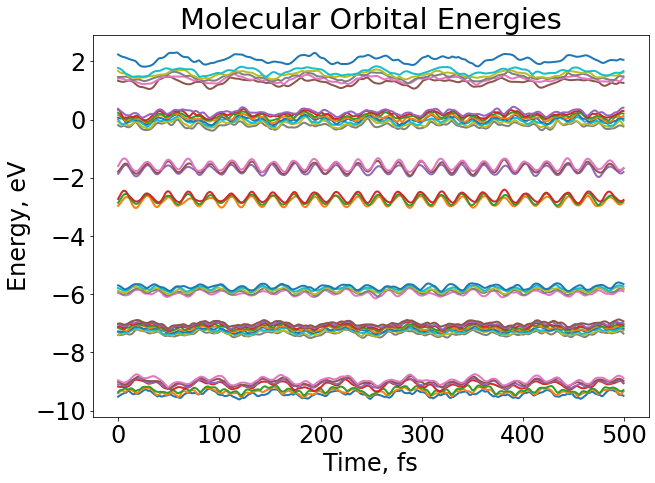

In [19]:
%matplotlib inline
fs = 24
plt.rcParams.update({'font.size': fs})
plt.figure(figsize=(3.21*3, 2.41*3))
# reading the energies
energies = []
for step in range(1000,1500):
    tmp = np.diag(sp.load_npz(f"{params['res_dir']}/E_ks_{step}.npz").real.todense())
    tmp = tmp[0:int(tmp.shape[0]/2)] # Only the energies of alpha orbitals
    energies.append(tmp)
energies = np.array(energies)*units.au2ev
for i in range(energies.shape[1]):
    plt.plot(energies[:,i], lw=2.0)
plt.title('Molecular Orbital Energies')
plt.ylabel('Energy, eV')
plt.xlabel('Time, fs')
plt.tight_layout()